In [1]:
import os
print(os.getcwd())

/home/jupyter-bryan/ISA_Data


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, Layer, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda, Reshape, Flatten, Input, MultiHeadAttention, Flatten, Concatenate, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import torch

2025-12-12 14:04:56.644107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def clean_and_interpolate(data):
    df = pd.DataFrame(data).astype(np.float32)
     
    df_linear = df.interpolate(method='linear', limit_direction='both', axis=1, limit=None)
    df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

    df_final = df_spline.fillna(0)
    
    # Clip extreme values
    df_interpolated_fin = df_final.clip(-1e6, 1e6)
    print(f"Final NaN count: {df_interpolated_fin.isnull().sum().sum()}")
    result = df_interpolated_fin.values
    
    return result

In [5]:
# Slope + elevation - fixed constraint
def binary_focal_loss_slope_elevation_constraint(slope_values, elevation_values,
                                                 slope_threshold=40, elevation_threshold=2000,
                                                 alpha=0.25, gamma=2.0,
                                                 lambda_slope=0.4, lambda_elevation=0.3):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        ce = -y_true * tf.math.log(y_pred_clipped)
        p_t = tf.where(tf.equal(y_true, 1), y_pred_clipped, 1 - y_pred_clipped)
        
        # Alpha weighting for class imbalance
        alpha_t = tf.where(tf.equal(y_true[:, 1], 1), alpha, 1 - alpha)
        
        # Focal loss calculation
        focal_weight = tf.expand_dims(alpha_t, 1) * tf.pow((1 - p_t), gamma)
        focal_loss = focal_weight * ce
        focal_loss = tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
        
        # Get batch data
        batch_size = tf.shape(y_pred)[0]
        slope_batch = tf.gather(slope_values, tf.range(batch_size))
        elevation_batch = tf.gather(elevation_values, tf.range(batch_size))
        
        # ISA predictions (class at index 1)
        isa_pred = y_pred[:, 1]
        
        # CONSTRAINT 1: Slope constraint
        slope_mask = tf.cast(slope_batch > slope_threshold, tf.float32)
        slope_penalty = tf.reduce_mean(tf.multiply(slope_mask, isa_pred))
        
        # CONSTRAINT 2: Elevation constraint
        elevation_mask = tf.cast(elevation_batch > elevation_threshold, tf.float32)
        elevation_penalty = tf.reduce_mean(tf.multiply(elevation_mask, isa_pred))
        
        # Combine all losses
        total_loss = focal_loss + (lambda_slope * slope_penalty) + (lambda_elevation * elevation_penalty)
        
        return total_loss
    
    return loss

In [6]:
def prepare_multi_region_data(citarum_01_paths, citarum_02_paths, citarum_03_paths, jkt_paths):
    def load_region_data(paths):
        # Load all dataframes for a region
        ndvi_df = pd.read_csv(paths['ndvi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        mndwi_df = pd.read_csv(paths['mndwi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbi_df = pd.read_csv(paths['ndbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbsi_df = pd.read_csv(paths['ndbsi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        cbi_df = pd.read_csv(paths['cbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        uci_df = pd.read_csv(paths['uci'],delimiter=';', encoding='utf-8-sig',decimal=',')
        print('NDVI shape before int:', ndvi_df.shape)
        
        # Extract features
        ndvi_features = ndvi_df.iloc[:,5:29].values
        mndwi_features = mndwi_df.iloc[:,5:29].values
        ndbi_features = ndbi_df.iloc[:,5:29].values
        ndbsi_features = ndbsi_df.iloc[:,5:29].values
        cbi_features = cbi_df.iloc[:,5:29].values
        uci_features = uci_df.iloc[:,5:29].values
        print('NDVI shape after int:', ndvi_features.shape)
        
        # Clean and interpolate
        ndvi_features = clean_and_interpolate(ndvi_features)
        mndwi_features = clean_and_interpolate(mndwi_features)
        ndbi_features = clean_and_interpolate(ndbi_features)
        ndbsi_features = clean_and_interpolate(ndbsi_features)
        cbi_features = clean_and_interpolate(cbi_features)
        uci_features = clean_and_interpolate(uci_features)
        
        # Combine features
        X = np.concatenate([ndvi_features, mndwi_features, ndbi_features, 
                            ndbsi_features, cbi_features, uci_features], axis=1)
        
        # Reshape
        X = X.reshape(X.shape[0], 24, 6) 
        
        # Get labels, slope and elev
        labels = ndvi_df.iloc[:, 2].values
        slope_values = ndvi_df.iloc[:,29].values
        elev_values = ndvi_df.iloc[:,30].values
        
        # return X, labels, slope_values
        return X, labels, slope_values, elev_values

    # Load data for both regions
    X_citarum_01, labels_citarum_01, slope_citarum_01, elev_citarum_01 = load_region_data(citarum_01_paths)
    X_citarum_02, labels_citarum_02, slope_citarum_02, elev_citarum_02 = load_region_data(citarum_02_paths)
    X_citarum_03, labels_citarum_03, slope_citarum_03, elev_citarum_03 = load_region_data(citarum_03_paths)
    X_jkt, labels_jkt, slope_jkt, elev_jkt = load_region_data(jkt_paths)
    
    # Combine data from both regions
    X_combined = np.concatenate([X_citarum_01, X_citarum_02, X_citarum_03, X_jkt], axis=0)
    labels_combined = np.concatenate([labels_citarum_01, labels_citarum_02, labels_citarum_03, labels_jkt])
    slope_combined = np.concatenate([slope_citarum_01, slope_citarum_02, slope_citarum_03, slope_jkt])
    elev_combined = np.concatenate([elev_citarum_01, elev_citarum_02, elev_citarum_03, elev_jkt])
    
    # Compute class weights on combined data
    unique_classes, counts = np.unique(labels_combined, return_counts=True)

    print("Labels combined shape:", labels_combined.shape)
    print("Labels combined type:", type(labels_combined[0]) if len(labels_combined) > 0 else "Empty")
    print("Unique classes from np.unique:", unique_classes)
    print("Number of counts per unique class:", counts)
    print("Unique classes type:", type(unique_classes[0]) if len(unique_classes) > 0 else "Empty")
    print("All unique values in labels_combined:", set(labels_combined))
    print("Any NaN values?", np.any(pd.isna(labels_combined)))

    # Check if there are any labels in y that aren't in classes
    missing_labels = set(labels_combined) - set(unique_classes)
    print("Labels in y but not in classes:", missing_labels)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_combined)
    
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
    y = np.asarray(labels_combined)
    print(y)
    print(len(np.unique(y)))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_combined = label_encoder.fit_transform(labels_combined)
    y_combined = to_categorical(y_combined)
    print(y_combined)
    
    # Split combined data
    X_train, X_test, y_train, y_test, slope_train, slope_test, elev_train, elev_test = train_test_split(X_combined, y_combined, 
                                                                                                        slope_combined, elev_combined,
                                                                                                        test_size=0.3,random_state=42,
                                                                                                        stratify=y_combined)
    
    # Convert slope values to tensorflow constant
    slope_train = tf.constant(slope_train, dtype=tf.float32)
    slope_test = tf.constant(slope_test, dtype=tf.float32)

    # Convert elev values to tensorflow constant
    elev_train = tf.constant(elev_train, dtype=tf.float32)
    elev_test = tf.constant(elev_test, dtype=tf.float32)
    
    return (X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y)

In [7]:
citarum_01_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_01.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_01.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_01.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_01.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_01.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_01.csv'
}

citarum_02_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_02.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_02.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_02.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_02.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_02.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_02.csv'
}

citarum_03_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_03.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_03.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_03.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_03.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_03.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_03.csv'
}

jkt_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_UCI.csv'
}

# Prepare the combined data
X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y = prepare_multi_region_data(citarum_01_paths, 
                                                                                                                                                      citarum_02_paths, 
                                                                                                                                                      citarum_03_paths,
                                                                                                                                                      jkt_paths)

NDVI shape before int: (2473, 31)
NDVI shape after int: (2473, 24)
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
NDVI shape before int: (1972, 31)
NDVI shape after int: (1972, 24)
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with

Final NaN count: 0
Final NaN count: 0
NDVI shape before int: (533, 31)
NDVI shape after int: (533, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with

NDVI shape before int: (2205, 31)
NDVI shape after int: (2205, 24)
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_2286221/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Labels combined shape: (7183,)
Labels combined type: <class 'numpy.int64'>
Unique classes from np.unique: [0 1]
Number of counts per unique class: [3247 3936]
Unique classes type: <class 'numpy.int64'>
All unique values in labels_combined: {np.int64(0), np.int64(1)}
Any NaN values? False
Labels in y but not in classes: set()
Class weights: {0: np.float64(1.1060979365568218), 1: np.float64(0.912474593495935)}
[0 0 0 ... 1 1 1]
2
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


I0000 00:00:1765519502.933702 2286221 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7766 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

tf.keras.utils.get_custom_objects().update({'swish': swish})

def ReshapeLayer(x):
    shape = x.shape
    # 1 possibility: H,W*channel
    reshape = Reshape((shape[1],shape[2]))(x)
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    return reshape

# def self_attention_block(x, dim):
#     q = Dense(dim)(x)
#     k = Dense(dim)(x)
#     v = Dense(dim)(x)
#     scores = tf.matmul(q, k, transpose_b=True)
#     attention_weights = tf.nn.softmax(scores / tf.sqrt(tf.cast(dim, tf.float32)))
    
#     return tf.matmul(attention_weights, v)

def self_attention_block(x, dim):    
    q = Dense(dim)(x)  # (batch, seq_len, dim)
    k = Dense(dim)(x)  # (batch, seq_len, dim)
    v = Dense(dim)(x)  # (batch, seq_len, dim)
    
    # Compute attention scores with proper batch handling
    scores = tf.matmul(q, k, transpose_b=True)  # (batch, seq_len, seq_len)
    scores = scores / tf.sqrt(tf.cast(dim, tf.float32))
    
    attention_weights = tf.nn.softmax(scores, axis=-1)  # (batch, seq_len, seq_len)
    
    output = tf.matmul(attention_weights, v)  # (batch, seq_len, dim)
    
    return output

In [9]:
n_classes=len(label_encoder.classes_)

def make_model(n_classes, n_timesteps=24, n_features=6):
    input_layer = Input(shape=(n_timesteps, n_features))
    
    x0a = Conv1D(16, 3, activation="swish", padding = 'same')(input_layer)
    x01a = Conv1D(32, 3, activation="swish", padding = 'same')(x0a)
    x01a = Conv1D(64, 3, activation="swish", padding = 'same')(x01a)
    
    x02a = Conv1D(64, 3, activation="swish", padding = 'same')(x01a)
    x02a = Conv1D(64, 3, activation="swish", padding = 'same')(x02a)

    x03a = Conv1D(64, 3, activation="swish", padding = 'same')(x02a)
    x03a = Conv1D(64, 3, activation="swish", padding = 'same')(x03a)

    xa = tf.keras.layers.add([x01a, x03a])

    x0b = Conv1D(16, 3, activation="swish", padding = 'same')(input_layer)
    x01b = Conv1D(32, 3, activation="swish", padding = 'same')(x0b)
    x01b = Conv1D(64, 3, activation="swish", padding = 'same')(x01b)
    
    x02b = Conv1D(64, 3, activation="swish", padding = 'same')(x01b)
    x02b = Conv1D(64, 3, activation="swish", padding = 'same')(x02b)

    x03b = Conv1D(64, 3, activation="swish", padding = 'same')(x02b)
    x03b = Conv1D(64, 3, activation="swish", padding = 'same')(x03b)

    xb = tf.keras.layers.add([x01b, x03b])

    conc_ = Concatenate()([xa, xb])

    x0c = Conv1D(64, 3, activation="relu", padding = 'same')(conc_)
    x0c = Conv1D(64, 3, activation="relu", padding = 'same')(x0c)
    x0c = LayerNormalization()(x0c)
    # x0b = SpatialDropout1D(0.25)(x0b)
    
    x_ft = Flatten()(x0c)
    
#     attention = MultiHeadAttention(num_heads=8, key_dim=64)(xab, xab, xab)
#     attention = Dropout(0.5)(attention)
#     attention = LayerNormalization()(attention + xab)
    
#     xfin = Bidirectional(GRU(64, activation='tanh', return_sequences=False))(attention)
#     xfin = Dropout(0.5)(xfin)
    
#     xfin = Dense(128, activation='swish')(xfin)
#     xfin = Dropout(0.5)(xfin)

#     x_att = swin_transformer_block(xab, embed_dim=64, num_heads=8, 
#                                     window_size=6,depth=2)

#     x_att = self_attention_block(xab, 64)

#     x_tcn = tcn_block(xab, num_levels=4,filters=64,
#                       kernel_size=3,
#                       dropout_rate=0.2)
    
#     x_tcn = tcn_sequence(input_layer, filter_number=64, kernel_size=3, num_blocks=4)
#     x_tcn = Flatten()(x_tcn)
#     x_tcn = Dropout(0.5)(x_tcn)
    
    # x_att = self_attention_block(conc_, 32)
    # x_att = Flatten()(x_att)
    
    x_gru = Bidirectional(GRU(32, activation='tanh', return_sequences=True))(conc_)
    x_gru = Bidirectional(GRU(64, activation='tanh', return_sequences=False))(x_gru)
    x_gru = LayerNormalization()(x_gru)
    
    x_conc = Concatenate()([x_gru, x_ft])
    x_conc = Dense(64, activation='relu')(x_conc)
    
    output_layer = Dense(n_classes, activation="softmax")(x_conc)

    return Model(inputs=input_layer, outputs=output_layer)

model = make_model(n_classes=len(label_encoder.classes_))
model.summary()

model.compile(loss=binary_focal_loss_slope_elevation_constraint(
                    slope_train, elev_train,  
                    slope_threshold=40, elevation_threshold=2000,
                    alpha=0.25, gamma=2.0, lambda_slope=0.4, lambda_elevation=0.3),
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#               optimizer=Adam(learning_rate=0.001), 
#               metrics=['accuracy'])

# model.compile(loss=custom_loss_with_slope_constraint(
#                     slope_train, 
#                     slope_threshold=40),
#               optimizer=Adam(learning_rate=0.001), 
#               metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Binary_Orig.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=100,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1,
                              patience=30, 
                              min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size =20,
                    epochs=500, 
                    callbacks = [checkpoint, early_stop, reduce_lr], 
                    class_weight = class_weight_dict)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 16)    │        304 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 24, 16)    │        304 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 32)    │      1,568 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 24, 32)    │      1,568 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 64)    │      6,208 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 24, 64)    │      6,208 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 24, 64)    │     12,352 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 24, 64)    │     12,352 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 24, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 24, 64)    │     12,352 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 24, 64)    │     12,352 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 64)    │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 128)   │          0 │ add[0][0],        │
│ (Concatenate)       │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 24, 64)    │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 64)    │     31,104 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 24, 64)    │     12,352 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     49,920 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                 

 Total params: 340,066 (1.30 MB)

 Trainable params: 340,066 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


2025-12-12 14:05:10.503890: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8727 - loss: 0.0883
Epoch 1: val_accuracy improved from None to 0.95313, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Binary_Orig.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8988 - loss: 0.0789 - val_accuracy: 0.9531 - val_loss: 0.0754 - learning_rate: 0.0010
Epoch 2/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9388 - loss: 0.0731
Epoch 2: val_accuracy improved from 0.95313 to 0.95824, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Binary_Orig.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9389 - loss: 0.0738 - val_accuracy: 0.9582 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 3/500
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9564 - loss: 0.0731
Epoch 3: val_accuracy improved from 0.95824 to 0.95963, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Binary_Orig.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9493 - loss: 0.07

In [10]:
print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)

X_train dtype: float32
X_test dtype: float32
y_train dtype: float64
y_test dtype: float64


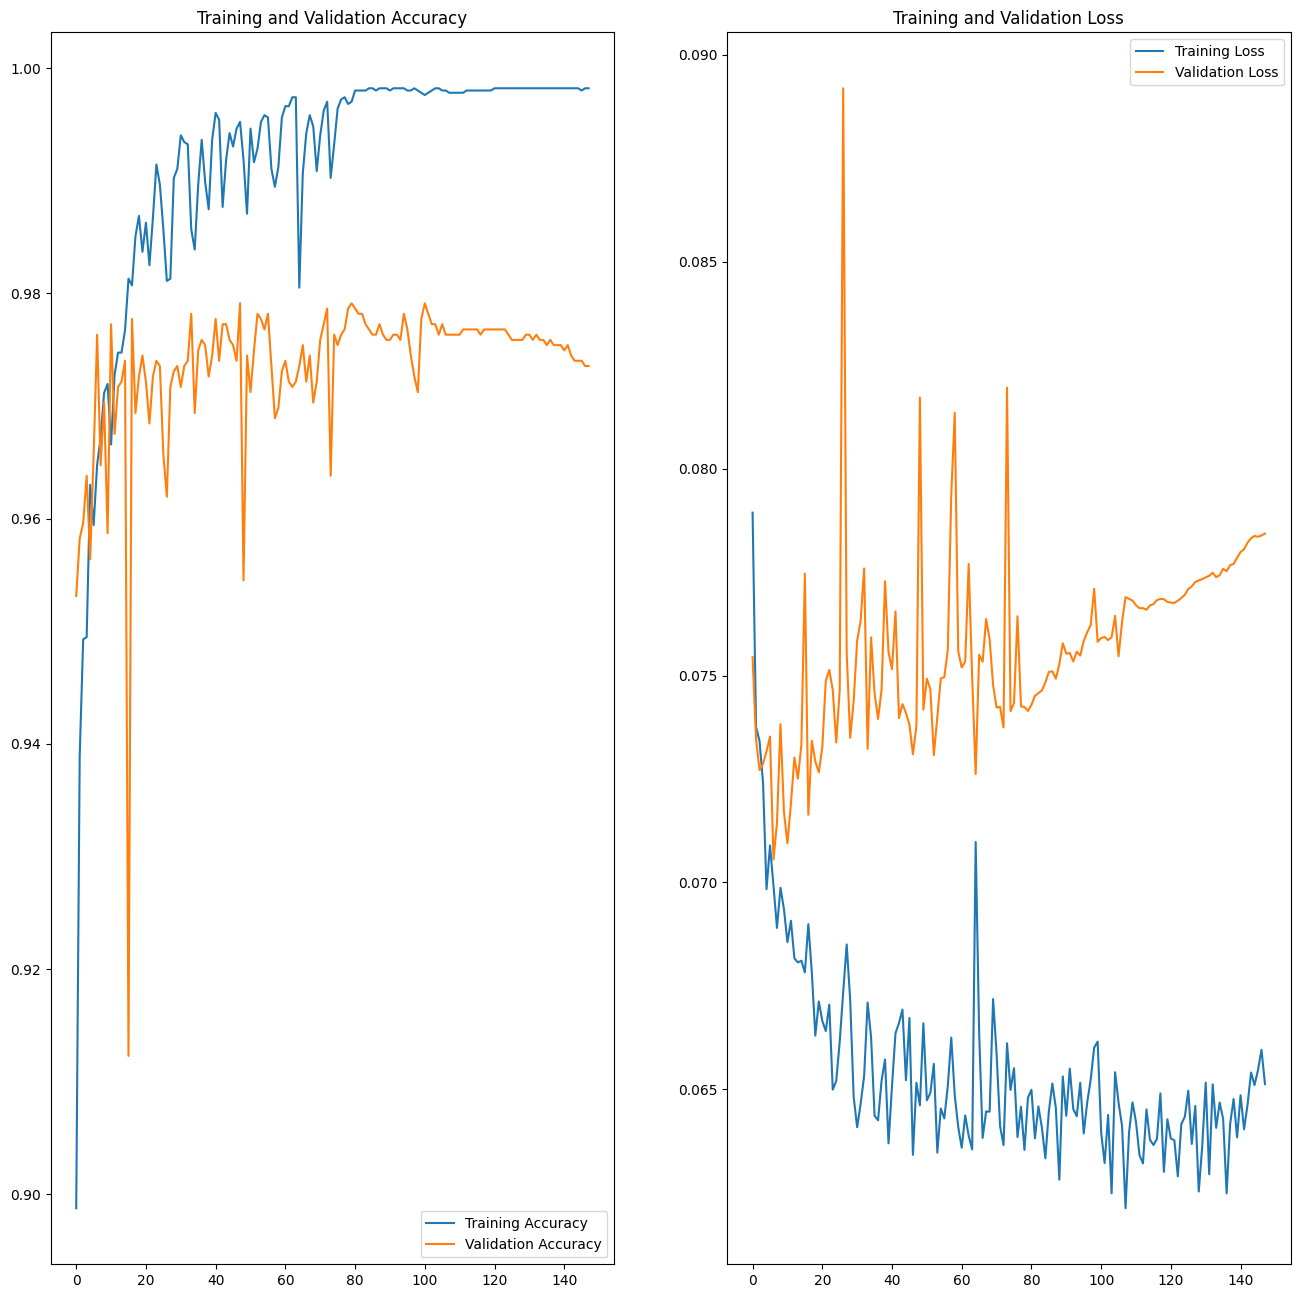

In [11]:
n_epochs = len(history.history['loss'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epochs) #change it based on epoch needed to finish building the model

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


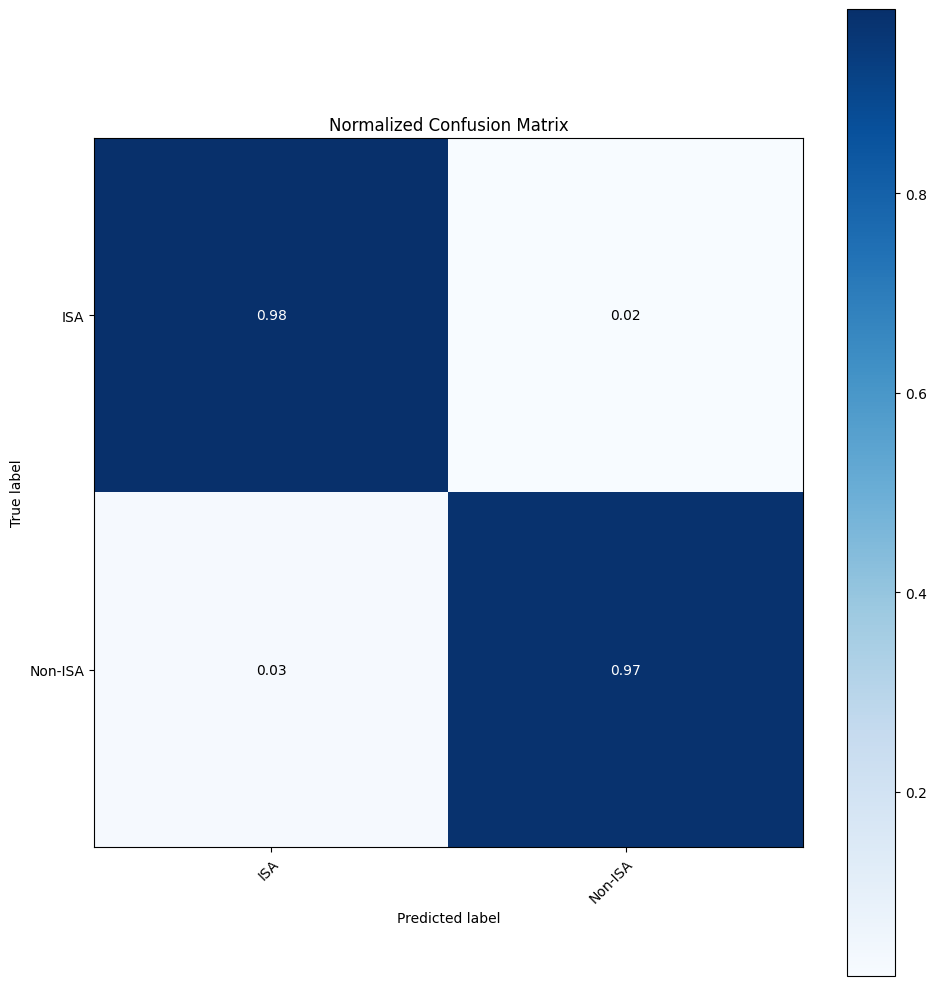

In [12]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['ISA','Non-ISA']

y_pred = np.argmax(model.predict(X_test), axis=1)
# y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dl_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(dl_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)


# Show all labels
ax.set(xticks=np.arange(dl_cm.shape[1]),
        yticks=np.arange(dl_cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title='Normalized Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = dl_cm.max() / 2.
for i in range(dl_cm.shape[0]):
    for j in range(dl_cm.shape[1]):
        ax.text(j, i, format(dl_cm[i, j], fmt),
                ha="center", va="center",
                color="white" if dl_cm[i, j] > thresh else "black")
fig.tight_layout()

In [13]:
def permutation_importance_predict(model, X_test, y_test, feature_names, n_repeats=5):
    X_test = np.array(X_test, dtype=np.float32)
    
    # Debug: Check shapes
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    # Get baseline predictions
    baseline_pred = model.predict(X_test, verbose=0)
    print(f"baseline_pred shape: {baseline_pred.shape}")
    
    # Handle different y_test formats
    if len(y_test.shape) == 1:
        # If y_test is 1D (class indices), use it directly
        y_true_classes = y_test
    else:
        # If y_test is one-hot encoded, convert to class indices
        y_true_classes = np.argmax(y_test, axis=1)
    
    # Convert predictions to class indices
    baseline_pred_classes = np.argmax(baseline_pred, axis=1)
    
    baseline_acc = np.mean(baseline_pred_classes == y_true_classes)
    print(f"Baseline accuracy: {baseline_acc:.4f}")
    
    importance_scores = {}
    
    for i, feature_name in enumerate(feature_names):
        print(f"Computing importance for {feature_name}...")
        
        scores = []
        for repeat in range(n_repeats):
            X_test_perm = np.copy(X_test).astype(np.float32)
            
            # Permute feature i across all time steps
            for t in range(X_test.shape[1]):
                np.random.shuffle(X_test_perm[:, t, i])
            
            # Use predict instead of evaluate
            perm_pred = model.predict(X_test_perm, verbose=0)
            perm_pred_classes = np.argmax(perm_pred, axis=1)
            perm_acc = np.mean(perm_pred_classes == y_true_classes)
            importance_drop = baseline_acc - perm_acc
            scores.append(importance_drop)
        
        importance_scores[feature_name] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'scores': scores
        }
        
        print(f"{feature_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    return importance_scores

In [14]:
def plot_feature_importance(importance_scores):
    import matplotlib.pyplot as plt
    
    features = list(importance_scores.keys())
    means = [importance_scores[f]['mean'] for f in features]
    stds = [importance_scores[f]['std'] for f in features]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(features, means, yerr=stds, capsize=5, alpha=0.7)
    plt.ylabel('Importance Score (Accuracy Drop)')
    plt.title('Feature Importance (Permutation-based)')
    plt.xticks(rotation=0)
    
    # Add value labels on bars
    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{mean:.3f}', ha='center', va='bottom')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

X_test shape: (2155, 24, 6)
y_test shape: (2155,)
baseline_pred shape: (2155, 2)
Baseline accuracy: 0.9791
Computing importance for NDVI...
NDVI: 0.0191 ± 0.0022
Computing importance for MNDWI...
MNDWI: 0.0194 ± 0.0015
Computing importance for NDBI...
NDBI: 0.0457 ± 0.0032
Computing importance for NDBSI...
NDBSI: 0.0182 ± 0.0024
Computing importance for CBI...
CBI: 0.0277 ± 0.0029
Computing importance for UCI...
UCI: 0.0490 ± 0.0080


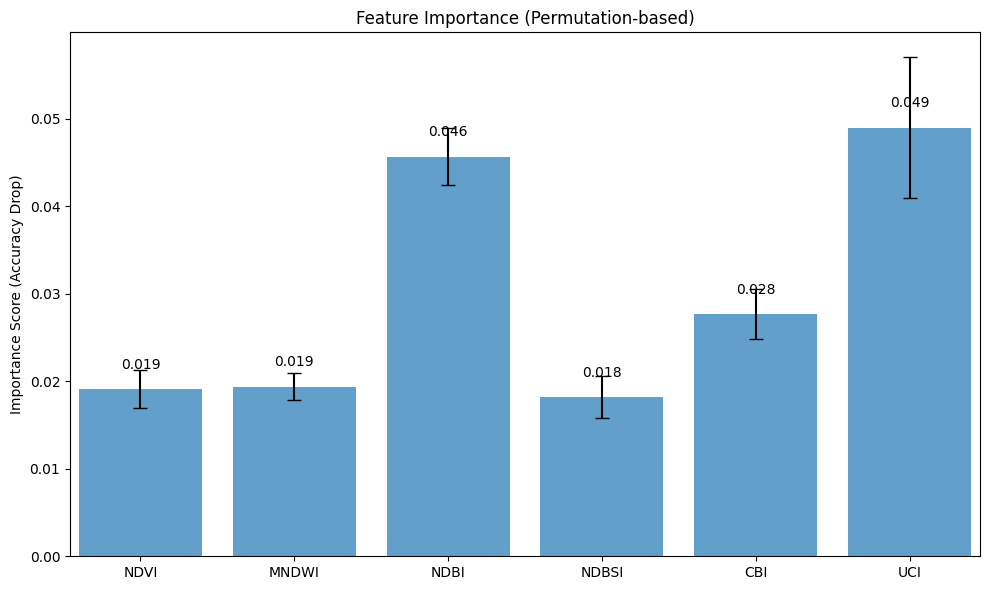


Feature Importance Ranking:
1. UCI: 0.0490 ± 0.0080
2. NDBI: 0.0457 ± 0.0032
3. CBI: 0.0277 ± 0.0029
4. MNDWI: 0.0194 ± 0.0015
5. NDVI: 0.0191 ± 0.0022
6. NDBSI: 0.0182 ± 0.0024


In [15]:
feature_names = ['NDVI', 'MNDWI', 'NDBI', 'NDBSI', 'CBI', 'UCI']
importance_results = permutation_importance_predict(model, X_test, y_test, feature_names, n_repeats=5)

plot_feature_importance(importance_results)
sorted_features = sorted(importance_results.items(), key=lambda x: x[1]['mean'], reverse=True)
print("\nFeature Importance Ranking:")
for i, (feature, scores) in enumerate(sorted_features, 1):
    print(f"{i}. {feature}: {scores['mean']:.4f} ± {scores['std']:.4f}")